In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


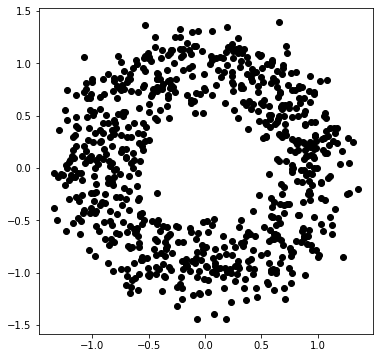

In [2]:
from datasets.mass_spring import getMassSpringVectorFieldDataset

N_samples = 750
H_min = 0.2
H_max = 0.8
sigma = 1e-1

dataset = getMassSpringVectorFieldDataset(N_samples, H_min, H_max, sigma, seed=None)

train_size = 70 * N_samples // 100
test_size = N_samples - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

plt.figure(figsize=(6,6))
plt.plot(dataset.y[:,0], dataset.y[:,1], 'ko');

In [3]:


from models.hernn import HamiltonianExtendedResidualNeuralNetwork
from models.ernn import ExtendedResidualNeuralNetwork

d = 1
depth = 5
expansion = 10
hrnn_model = HamiltonianExtendedResidualNeuralNetwork(d, depth, expansion, activation=nn.Tanh()).to(device)
print(hrnn_model)

d = 1
depth = 5
expansion = 10
rnn_model = ExtendedResidualNeuralNetwork(2*d, depth, expansion, activation=nn.Tanh()).to(device)
print(rnn_model)

from tools.integrate import *
model_int_method = rk4

loss_fn = nn.MSELoss()

wd = 1e-5
hrnn_optimizer = torch.optim.Adam(hrnn_model.parameters(),lr=1e-3, weight_decay=wd)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(),lr=1e-3, weight_decay=wd)

print(hrnn_optimizer)
print(rnn_optimizer)


HamiltonianExtendedResidualNeuralNetwork(
  (activation): Tanh()
  (linear_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (linear_to_hamiltonian): Linear(in_features=20, out_features=1, bias=True)
)
ExtendedResidualNeuralNetwork(
  (linear_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (linear_collapse): Linear(in_features=20, out_features=2, bias=True)
  (activation): Tanh()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (

In [4]:
from tools.integrate import *
from tools.train import *

vec_epochs = 100
hrnn_losses = train_loop(train_dataloader, test_dataloader, hrnn_model, loss_fn, 
                                                    hrnn_optimizer, vec_epochs, lr=None)
rnn_losses = train_loop(train_dataloader, test_dataloader, rnn_model, loss_fn, 
                                                    rnn_optimizer, vec_epochs, lr=None)


Epoch  10 / 100 --------- Avg loss: 0.093962
Epoch  20 / 100 --------- Avg loss: 0.020767
Epoch  30 / 100 --------- Avg loss: 0.014396
Epoch  40 / 100 --------- Avg loss: 0.012392
Epoch  50 / 100 --------- Avg loss: 0.011664
Epoch  60 / 100 --------- Avg loss: 0.011381
Epoch  70 / 100 --------- Avg loss: 0.011261
Epoch  80 / 100 --------- Avg loss: 0.011207
Epoch  90 / 100 --------- Avg loss: 0.011181
Epoch 100 / 100 --------- Avg loss: 0.011165

Done!
Epoch  10 / 100 --------- Avg loss: 0.015657
Epoch  20 / 100 --------- Avg loss: 0.013744
Epoch  30 / 100 --------- Avg loss: 0.012783
Epoch  40 / 100 --------- Avg loss: 0.012265
Epoch  50 / 100 --------- Avg loss: 0.011965
Epoch  60 / 100 --------- Avg loss: 0.011777
Epoch  70 / 100 --------- Avg loss: 0.011650
Epoch  80 / 100 --------- Avg loss: 0.011558
Epoch  90 / 100 --------- Avg loss: 0.011487
Epoch 100 / 100 --------- Avg loss: 0.011430

Done!


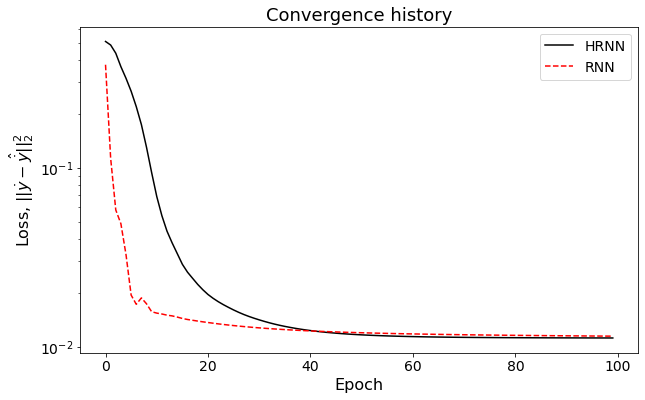

In [9]:

plt.figure(figsize=(10,6))
plt.title("Convergence history", fontsize=18)
plt.semilogy(range(vec_epochs), hrnn_losses, 'k-', label="HRNN")# \n")# + \
                                                               #"$||\dot{y} - \hat{\dot{y}}||_2^2$")
plt.semilogy(range(vec_epochs), rnn_losses, 'r--', label="RNN")# \n")# + \
                                                                #"$||\dot{y} - \hat{\dot{y}}||_2^2$")
plt.legend(fontsize=14);
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss, $||\dot{y} - \hat{\dot{y}}||_2^2$", fontsize=16);

plt.tick_params(axis='both', which='major', labelsize=14);
plt.tick_params(axis='both', which='minor', labelsize=14)


plt.savefig("RNN-HRNN/convergence.png", dpi=200);


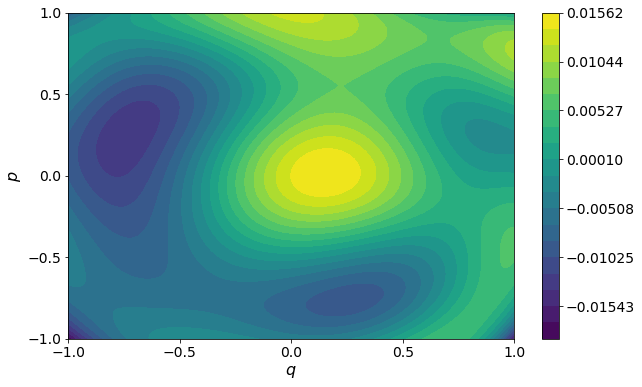

In [11]:

N_points = 301
x = np.linspace(-1.0, 1.0, N_points)
y = np.linspace(-1.0, 1.0, N_points)
X, Y = np.meshgrid(x, y)

m, k = 1.0, 1.0
H_ex_func = lambda q, p: 0.5 * p**2 / m + 0.5 * k * q**2
H_ex = H_ex_func(X, Y)

z = np.column_stack((X.flatten(), Y.flatten()))
H_hrnn = hrnn_model.hamiltonian(torch.tensor(z).float()).detach().numpy().reshape(N_points,N_points)


H_diff = H_hrnn - H_ex
H_diff = H_diff - np.mean(H_diff)

fig, ax = plt.subplots(figsize=(10,6))
cf2 = ax.contourf(X, Y, H_diff, levels=np.linspace(np.amin(H_diff), np.amax(H_diff), 21))
cbar = fig.colorbar(cf2, ax=ax)
cbar.ax.tick_params(labelsize=14)

ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0]);
ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0]);
ax.tick_params(axis='both', which='major', labelsize=14);
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel("$q$", fontsize=16)
ax.set_ylabel("$p$", fontsize=16)


fig.savefig("RNN-HRNN/hamiltonian_contourf.png", dpi=200);


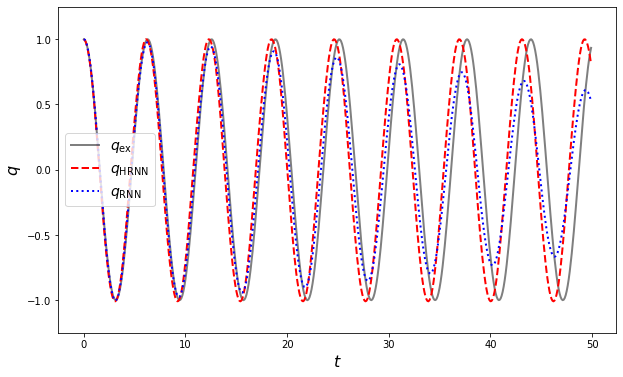

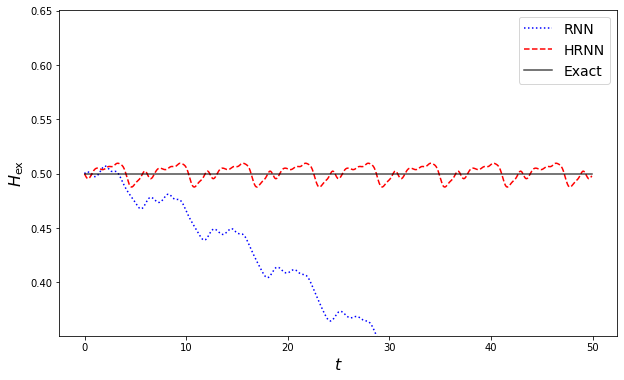

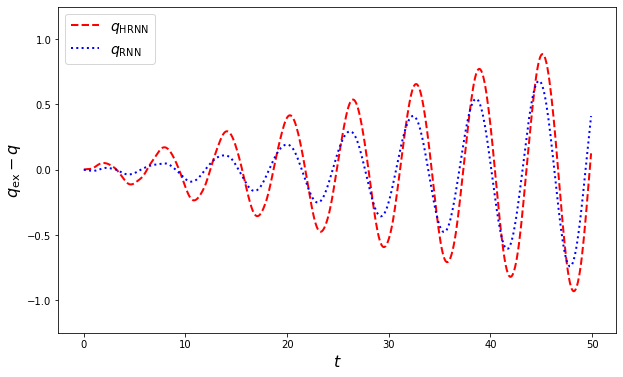

In [10]:

from IPython.display import display, HTML
display(HTML('<h1>Fixed step size</h1>'))

from tools.integrate import *

q0 = 1.0
p0 = 0.0

x0 = torch.tensor(np.array([q0, p0]).reshape(1,2)).float()

t0 = 0.0
T = 50.0
t_span = [t0, T]
t_eval = np.arange(t0, T, 0.1, dtype=np.float32)

hrnn_sol = integrate_model(hrnn_model, t_eval, x0, rk_method=model_int_method)
rnn_sol = integrate_model(rnn_model, t_eval, x0, rk_method=model_int_method)


# Extract the first trajectory of our one-length initial condition batch
q_hrnn = hrnn_sol[0,:,0].detach().numpy()
p_hrnn = hrnn_sol[0,:,1].detach().numpy()
q_rnn = rnn_sol[0,:,0].detach().numpy()
p_rnn = rnn_sol[0,:,1].detach().numpy()

m, k = 1.0, 1.0
w = np.sqrt(k / m)

ex_q = lambda t: q0 * np.cos(w * t) + p0 / (m*w) * np.sin(w * t)
ex_p = lambda t: -q0 * np.sqrt(k*m)*np.sin(w * t) + p0*np.cos(w * t)

q_ex = ex_q(t_eval)
p_ex = ex_p(t_eval)


plt.figure(figsize=(10,6))

plt.plot(t_eval, q_ex, 'k-', lw=2, alpha=0.5, label="$q_\mathrm{ex}$");
plt.plot(t_eval, q_hrnn, 'r--', lw=2, label="$q_\mathrm{HRNN}$");
plt.plot(t_eval, q_rnn, 'b:', lw=2, label="$q_\mathrm{RNN}$");
plt.xlabel("$t$", fontsize=16);
plt.ylabel("$q$", fontsize=16);
plt.ylim(-1.25*np.amax(np.abs(q_ex)), 1.25*np.amax(np.abs(q_ex)))
plt.legend(fontsize=14);

plt.savefig("RNN-HRNN/integrated.png", dpi=200)

plt.figure(figsize=(10,6))

plt.plot(t_eval, 1/(2*m) * p_rnn**2 + 1/2 * k * q_rnn**2, 'b:', label="RNN");
plt.plot(t_eval, 1/(2*m) * p_hrnn**2 + 1/2 * k * q_hrnn**2, 'r--', label="HRNN");
plt.plot(t_eval, 1/(2*m) * p_ex**2 + 1/2 * k * q_ex**2, 'k-', alpha=0.7, label="Exact");
plt.xlabel("$t$", fontsize=16);
plt.ylabel("$H_\mathrm{ex}$", fontsize=16);
mu = np.mean(1/(2*m) * p_hrnn**2 + 1/2 * k * q_hrnn**2)
s = np.amax(1/(2*m) * p_hrnn**2 + 1/2 * k * q_hrnn**2 - mu)
s = np.amax((s, 0.1))
plt.ylim(mu - 1.5*s, mu + 1.5*s)
plt.legend(fontsize=14);

plt.savefig("RNN-HRNN/hamiltonian.png", dpi=200);

plt.figure(figsize=(10,6))

plt.plot(t_eval, q_ex - q_hrnn, 'r--', lw=2, label="$q_\mathrm{HRNN}$");
plt.plot(t_eval, q_ex - q_rnn, 'b:', lw=2, label="$q_\mathrm{RNN}$");
plt.xlabel("$t$", fontsize=16);
plt.ylabel("$q_\mathrm{ex} - q$", fontsize=16);
plt.ylim(-1.25*np.amax(np.abs(q_ex)), 1.25*np.amax(np.abs(q_ex)))
plt.legend(fontsize=14);

plt.savefig("RNN-HRNN/error.png", dpi=200)




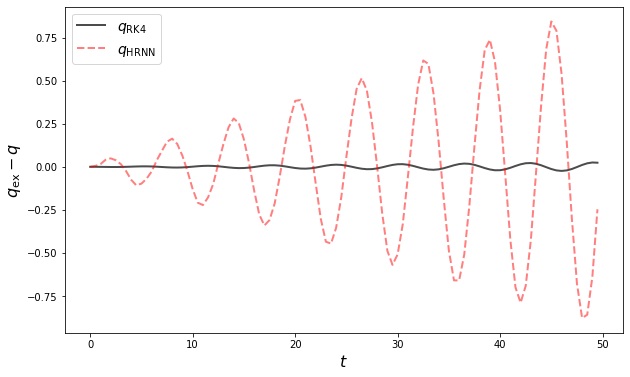

In [8]:
from IPython.display import display, HTML
display(HTML('<h1>Compared to RK4-integration of exact field, step size $0.5$.</h1>'))

def rk4_hm(f, y0, t_eval):
    """Non-batched, autonomous"""
    
    y = np.zeros((t_eval.shape[0], *y0.shape), dtype=y0.dtype)
    y[0,...] = y0
    
    y_n = y0
    for n, h in enumerate(np.diff(t_eval), start=1):
        
        k1 = f(y_n)
        k2 = f(y_n + 0.5*h*k1)
        k3 = f(y_n + 0.5*h*k2)
        k4 = f(y_n + 1.0*h*k3)
        
        y_n = y_n + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        y[n,...] = y_n
    
    return y


def f(y):
    
    return np.array([y[1], -y[0]], dtype=y.dtype)


t_eval = np.arange(t0, T, 0.5, dtype=np.float32)

hrnn_sol = integrate_model(hrnn_model, t_eval, x0, rk_method=rk4)


# Extract the first trajectory of our one-length initial condition batch
q_hrnn = hrnn_sol[0,:,0].detach().numpy()
p_hrnn = hrnn_sol[0,:,1].detach().numpy()

q_ex = ex_q(t_eval)
p_ex = ex_p(t_eval)

y_rk4 = rk4_hm(f, np.array([q0, p0]), t_eval)
q_rk4 = y_rk4[:,0]

plt.figure(figsize=(10,6))

plt.plot(t_eval, q_ex - q_rk4, 'k-', alpha=0.7, lw=2, label="$q_\mathrm{RK4}$");
plt.plot(t_eval, q_ex - q_hrnn, 'r--', lw=2, alpha=0.5, label="$q_\mathrm{HRNN}$");
plt.xlabel("$t$", fontsize=16);
plt.ylabel("$q_\mathrm{ex} - q$", fontsize=16);
plt.legend(fontsize=14);
plt.savefig("RNN-HRNN/rk4_diff.png", dpi=200)

    

In [12]:
"""Saving models"""

folder = "RNN-HRNN"

filename = "RNN"
torch.save(rnn_model.state_dict(), folder+"/"+filename+".pth")
print(f"Saved PyTorch Model State to {folder+'/'+filename}.pth")

filename = "HRNN"
torch.save(hrnn_model.state_dict(), folder+"/"+filename+".pth")
print(f"Saved PyTorch Model State to {folder+'/'+filename}.pth")


Saved PyTorch Model State to RNN-HRNN/RNN.pth
Saved PyTorch Model State to RNN-HRNN/HRNN.pth


In [ ]:
"""Loading model"""

folder = "HRNNvect-HRNNtraj"

filename = "RNN"
rnn_model.load_state_dict(torch.load(folder+"/"+filename+".pth"))

filename = "HRNN"
hrnn_model.load_state_dict(torch.load(folder+"/"+filename+".pth"))